In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff
import os
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.losses import BinaryCrossentropy

ModuleNotFoundError: No module named 'geopandas'

In [9]:
# Path to the shapefile and TIFF image
# shapefile_path = '/content/drive/MyDrive/Solid Waste/hhh/hhh.shp'
shapefile_path = 'final.shp'
# tiff_path = '/content/drive/MyDrive/Solid Waste/W7_clipped/hello.tif'
tiff_path = '/mnt/disk/solid_waste/interest.tif'

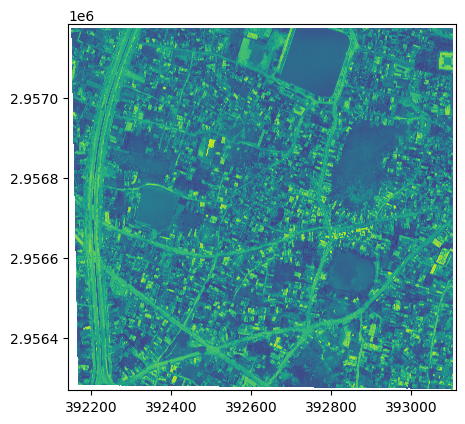

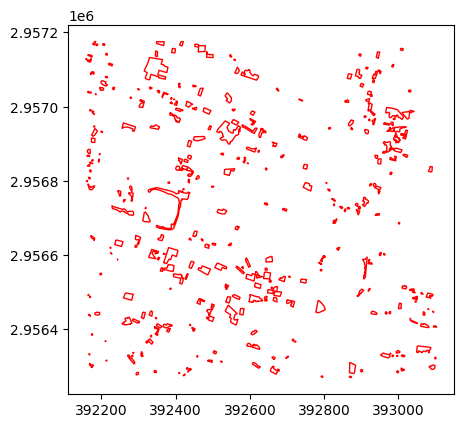

In [10]:
# Read the shapefile and TIFF image
gdf = gpd.read_file(shapefile_path)
src = rasterio.open(tiff_path)

# Plot the TIFF image
plt.figure(figsize=(5, 5))
show(src, cmap='viridis')

# Overlay the shapefile
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red')

plt.show()

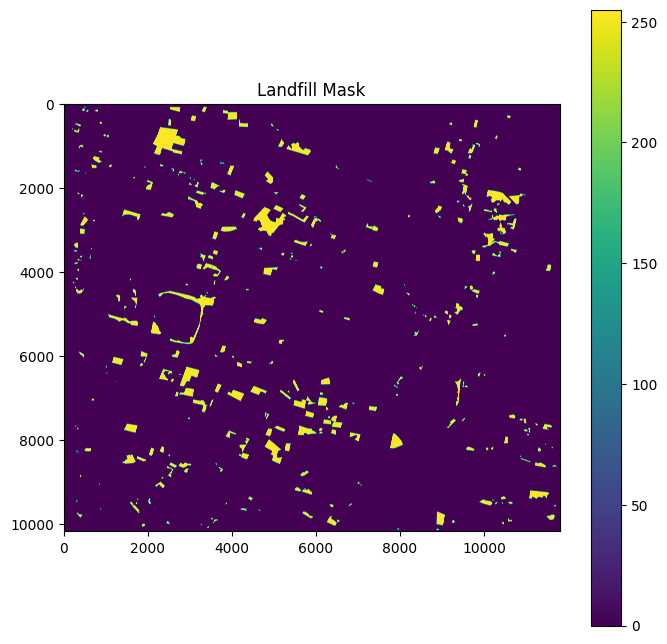

In [11]:
try:
    # Load the georeferenced TIFF image
    with rasterio.open(tiff_path) as src:
        out_image = src.read(1)  # Read the first band

        # Define the shape and transform of the geotiff
        out_meta = src.meta

        # Create a mask from the vector data
        mask = geometry_mask(gdf['geometry'], out_shape=out_image.shape, transform=out_meta['transform'], invert=True)

        # Update metadata for the raster mask
        out_meta.update(dtype='uint8', count=1, nodata=0)

        # Write the mask to a new geotiff file
        mask_output_path = 'maskout.tif'
        with rasterio.open(mask_output_path, 'w', **out_meta) as dest:
            dest.write(mask * 255, 1)  # Scaling the mask to 0-255 range

    # Open the mask file
    with rasterio.open(mask_output_path) as mask_src:
        mask_array = mask_src.read(1)

    # Plot the mask
    plt.figure(figsize=(8, 8))
    plt.imshow(mask_array)
    plt.title('Landfill Mask')
    plt.colorbar()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [12]:
out_image.shape

(10175, 11795)

In [13]:
 # Split the geotiff image and mask into smaller patches
patch_size = 256  # Define the patch size
step_size = 256  # Define the step size for overlapping patches
image_patches = patchify(out_image, (patch_size, patch_size), step=step_size)  # Patchify the image
mask_patches = patchify(mask_array, (patch_size, patch_size), step=step_size)  # Patchify the mask

In [14]:
print(image_patches.shape)
print(mask_patches.shape)

(39, 46, 256, 256)
(39, 46, 256, 256)


In [15]:
import numpy as np
# Split the patches into training, testing, and validation sets
X = np.array([image_patches[i, j, :, :] for i in range(image_patches.shape[0]) for j in range(image_patches.shape[1])])
y = np.array([mask_patches[i, j, :, :] for i in range(mask_patches.shape[0]) for j in range(mask_patches.shape[1])])

In [16]:
# Split the patches into training, testing, and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [17]:
X_train.shape

(1435, 256, 256)

In [18]:
# Print the lengths of the training and validation data
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

1435
1435
359
359


In [19]:
data_dir = 'Data'

# Modify the paths for the image and mask data directories
train_image_data_dir = 'Data/train_images/train'
train_mask_data_dir = 'Data/train_masks/train'
val_image_data_dir = 'Data/val_images/val'
val_mask_data_dir = 'Data/val_masks/val'




In [20]:
# Create the necessary directories if they don't exist
for directory in [data_dir, train_image_data_dir, train_mask_data_dir, val_image_data_dir, val_mask_data_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [21]:
# Save the images and masks to disk in separate folders
for i, data in enumerate(zip(X_train, y_train)):
    image_patch, mask_patch = data
    tiff.imwrite(f'{train_image_data_dir}/img_{i}.tiff', image_patch)
    tiff.imwrite(f'{train_mask_data_dir}/msk_{i}.tiff', mask_patch)

for i, data in enumerate(zip(X_val, y_val)):
    image_patch, mask_patch = data
    tiff.imwrite(f'{val_image_data_dir}/img_{i}.tiff', image_patch)
    tiff.imwrite(f'{val_mask_data_dir}/msk_{i}.tiff', mask_patch)

# for i, data in enumerate(zip(X_test, y_test)):
#     image_patch, mask_patch = data
#     tiff.imwrite(f'{test_image_data_dir}/img_{i}.tiff', image_patch)
#     tiff.imwrite(f'{test_mask_data_dir}/msk_{i}.tiff', mask_patch)

In [22]:
# Function to read an image and its mask from separate folders
def read_image_and_mask_separate(image_dir, mask_dir, index, data_type):
    image_path = f'{image_dir}/img_{index}.tiff'
    mask_path = f'{mask_dir}/msk_{index}.tiff'
    image = tiff.imread(image_path)
    mask = tiff.imread(mask_path)
    return image, mask

# Updated function to read the images and masks
def read_image_and_mask(image_dir, mask_dir, index, data_type):
    if data_type == 'train':
        return read_image_and_mask_separate(train_image_data_dir, train_mask_data_dir, index, data_type)
    elif data_type == 'val':
        return read_image_and_mask_separate(val_image_data_dir, val_mask_data_dir, index, data_type)
    # elif data_type == 'test':
    #     return read_image_and_mask_separate(test_image_data_dir, test_mask_data_dir, index, data_type)
    else:
        print("Invalid data type.")

In [23]:
# Update the data directories for images and masks
train_image_data_dir = 'Data/train_images/train'
train_mask_data_dir = 'Data/train_masks/train'
val_image_data_dir = 'Data/val_images/val'
val_mask_data_dir = 'Data/val_masks/val'
# test_image_data_dir = '/content/drive/MyDrive/Data/test_images/test'
# test_mask_data_dir = 'content/drive/MyDrive/Data/test_mask/test'

In [24]:
# Print the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)

Shape of X_train: (1435, 256, 256)
Shape of y_train: (1435, 256, 256)
Shape of X_val: (359, 256, 256)
Shape of y_val: (359, 256, 256)


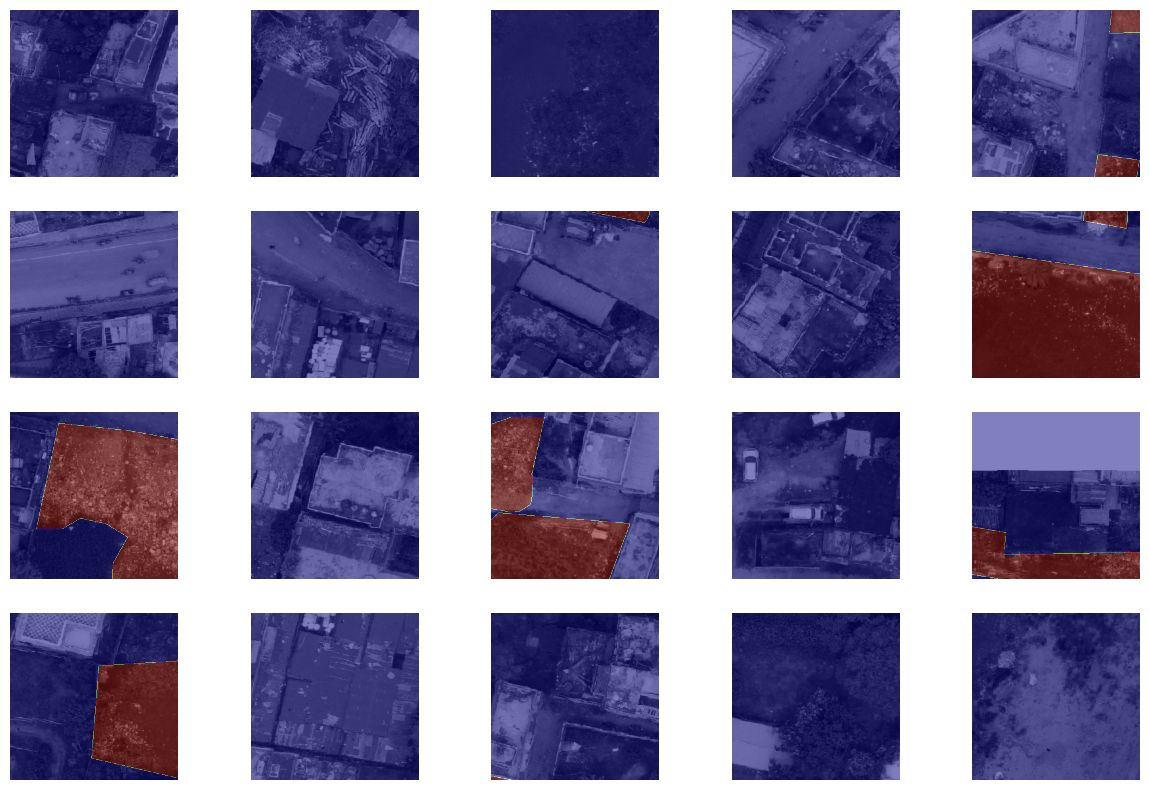

In [25]:
import random

# Choose 20 random indices
random_indices = random.sample(range(len(X_train)), 20)

# Choose 20 random images and masks
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Plot the selected images and masks
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(selected_images[i], cmap='gray')
    plt.imshow(selected_masks[i], alpha=0.5, cmap='jet')
    plt.axis('off')
plt.show()


In [26]:
# pip install -U segmentation-models

In [27]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

Segmentation Models: using `tf.keras` framework.


In [28]:
train_img_dir = "Data/train_images/train/"
train_mask_dir = "Data/train_masks/train/"

In [29]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [30]:
num_images = len(os.listdir(train_img_dir))
num_images

1435

In [31]:
seed=24
batch_size= 16
n_classes=2

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

In [33]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [34]:
def preprocess_data(img, mask, num_class):
    #Scale images
    # img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = (img - img.min()) / (img.max() - img.min())
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    # Normalize mask values to 0 and 1
    mask = mask / 255
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img,mask)

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)



In [36]:
train_img_path = "Data/train_images/"
train_mask_path = "Data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=2)

In [37]:
val_img_path = "Data/val_images/"
val_mask_path = "Data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=2)

In [38]:
# test_img_path = "Data/test_images/"
# test_mask_path = "Data/test_masks/"
# test_img_gen = trainGenerator(test_img_path, test_mask_path, num_class=2)

In [39]:
try:
    x, y = train_img_gen.__next__()

    # for i in range(0, 3):
    #     image = x[i]
    #     mask = np.argmax(y[i], axis=2)
    #     plt.figure(figsize=(10, 5))
    #     plt.subplot(1, 2, 1)
    #     plt.imshow(image, cmap='gray')
    #     plt.title('Image')
    #     plt.subplot(1, 2, 2)
    #     plt.imshow(mask, cmap='jet', alpha=0.5)
    #     plt.title('Mask')
    #     plt.show()

    x_val, y_val = val_img_gen.__next__()

except Exception as e:
    print(f"An error occurred: {e}")


Found 1435 images belonging to 1 classes.


Found 1435 images belonging to 1 classes.


/home/ncit/.anaconda/envs/vfcenv/lib/python3.9/site-packages/keras/src/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


Found 359 images belonging to 1 classes.
Found 359 images belonging to 1 classes.


In [2]:
num_train_imgs = len(os.listdir('Data/train_images/train/'))
num_val_images = len(os.listdir('Data/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

NameError: name 'os' is not defined

In [41]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
n_classes=2

In [58]:
# Define the model
model = sm.Unet(BACKBONE, encoder_weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='sigmoid')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score], run_eagerly=True)

In [59]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_34 (ZeroPad  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [60]:
print(model.input_shape)

(None, 256, 256, 3)


In [61]:
class_weights = {0: 1, 1: 7}

In [62]:
from keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='solidwaste_{epoch:02d}.hdf5',  # File path to save the model
    save_best_only=True,
    monitor='val_loss',   # Save the model at every epoch
    save_freq='epoch'  # Save the model after every epoch
)


In [64]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=2,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
          class_weight=class_weights,
          callbacks=[model_checkpoint])

Epoch 1/2
89/89 [==============================] - ETA: 0s - loss: 0.5579 - iou_score: 0.5433

/home/ncit/.anaconda/envs/vfcenv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 44s 497ms/step - loss: 0.5579 - iou_score: 0.5433 - val_loss: 0.5571 - val_iou_score: 0.4660
Epoch 2/2
89/89 [==============================] - 44s 493ms/step - loss: 0.4961 - iou_score: 0.6031 - val_loss: 0.5254 - val_iou_score: 0.4855


In [3]:
# Save the training history to a file
import pickle
# with open('training_history.pkl', 'wb') as file:
#     pickle.dump(history.history, file)

In [4]:
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

In [ ]:
model.save('UNET_RESNET_backbone.hdf5')
# havent include optimizer state. checkpoint

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


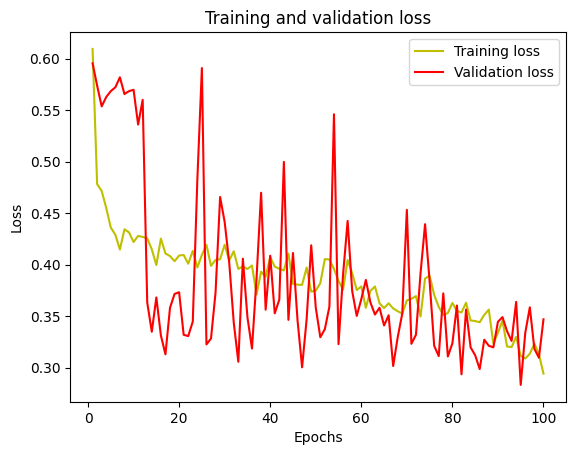

In [6]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

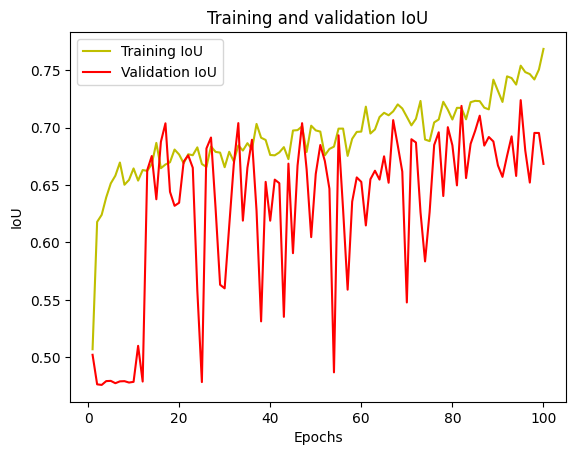

In [7]:
acc = history['iou_score']
val_acc = history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [42]:
from keras.models import load_model

In [43]:
model = load_model("solidwaste_95.hdf5", compile=False)

2023-11-27 22:36:09.335857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7399 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:21:00.0, compute capability: 6.1


In [177]:
#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 35ms/step
Mean IoU = 0.84422624


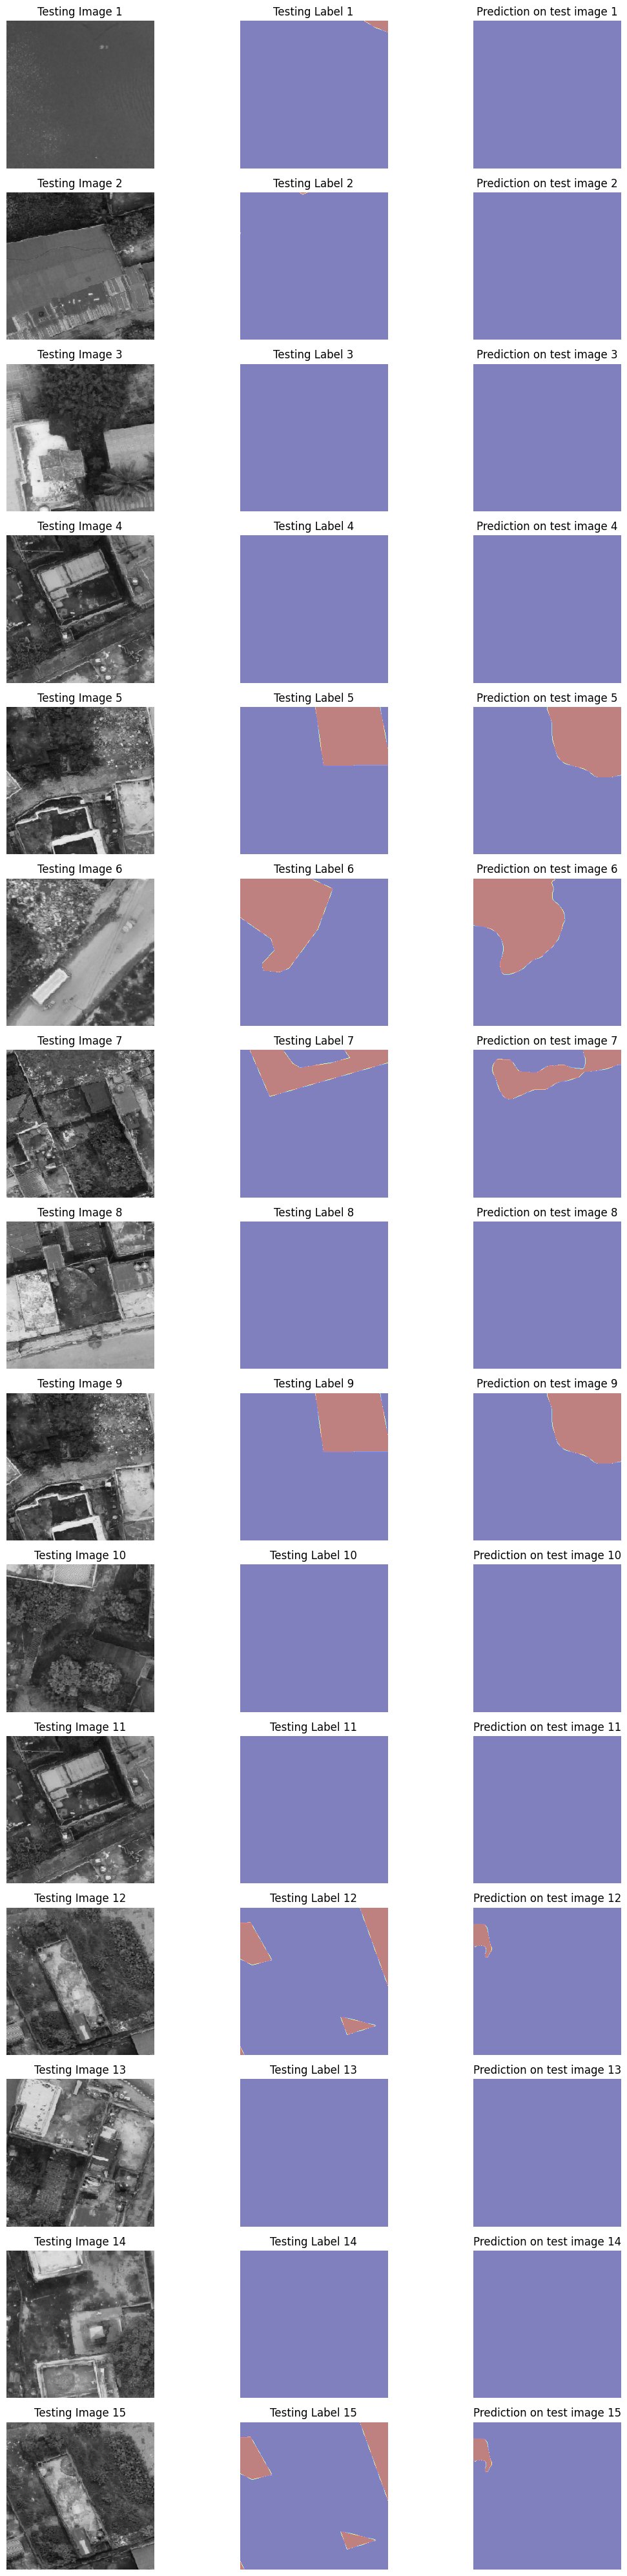

In [178]:
import random
import matplotlib.pyplot as plt

num_images = 15

plt.figure(figsize=(12,40))
for i in range(num_images):
    img_num = random.randint(0, test_image_batch.shape[0]-1)

    plt.subplot(num_images, 3, 3*i+1)
    plt.title(f'Testing Image {i+1}')
    plt.imshow(test_image_batch[img_num], cmap='gray')
    plt.axis('off')

    plt.subplot(num_images, 3, 3*i+2)
    plt.title(f'Testing Label {i+1}')
    plt.imshow(test_mask_batch_argmax[img_num], cmap='jet', alpha=0.5)
    plt.axis('off')

    plt.subplot(num_images, 3, 3*i+3)
    plt.title(f'Prediction on test image {i+1}')
    plt.imshow(test_pred_batch_argmax[img_num], cmap='jet', alpha=0.5)
    plt.axis('off')


plt.tight_layout()
plt.show()


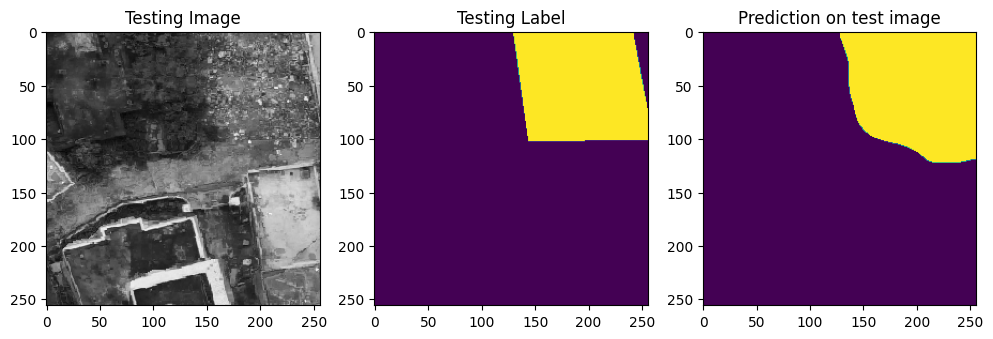

: 

In [183]:
#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()